# Implementing Walsh and Haar Transforms Using Python

## Table of Contents
* [Walsh Transform](#Walsh)
    * [Introduction](#WalshIntroduction)
    * [Python Implementation](#WalshImplementation)
    * [Testing](#WalshTesting)
* [Haar Transform](#Haar)
    * [Introduction](#HaarIntroduction)
    * [Python Implementation](#HaarImplementation)
    * [Testing](#HaarTesting)

<a name="Walsh"></a>
## The Walsh Transform

<a name="WalshIntroduction"></a>
### Introduction

The Walsh Transform is one way of transforming a signal/image from a space-domain to its corresponding frequency-domain. The DFT is a complex, sinusoidal transform while DCT is a transform where the imaginary values are eliminated and the real ones are retained. In the case of Walsh, it is a square waveform transform. In addition, the base/kernel functions in the Walsh tranformation are orthogonal, orthonormal and symmetric. Those in DFT are also symmetric. The forward walsh transform is as follows (Assume that N = $2^n$):

$
\begin{align}
H(u,v) = \frac{1}{N}\sum_{x=0}^{N-1}\sum_{y=0}^{N-1}f(x,y) (-1)^{ \beta } \;\\ where \; u,v=0,1,2,...N-1 \\
\beta = \sum_{i=0}^{n-1}b_i(x)b_i(u) + \sum_{i=0}^{n-1}b_i(y)b_i(v)
\end{align}
$

Since the kernels of the walsh transform are real and orthogonal, they are separable. The forward transform can be rewritten as:

$H(u,v) = k.f(x,y).k $

$ Where \; u,v=0,1,2,...N-1 \; and \; k = \sum_{i=0}^{n-1}b_i(x)b_i(u) $

Similarly, the inverse walsh transform will look as follows:

$f(x,y) = k.H(u,v).k $

This is exactly the same as that of the forward transformation as the kernels are real and symmetric. 

<a name="WalshImplementation"></a>
### Python Implementation

First of all, let's import the necessary python libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#import matplotlib.image as img
import PIL.Image as Image 

import math
import cmath

import time

import csv

from numpy import binary_repr


Now let's start with creating common image functions.

In [2]:
def generateImagesWithResizedWhite(imge):
    """
    Generates images with the same size as the original but with a resized white part of them.
    """

    N = imge.shape[0]

    imges = []
    i = N/2
    while i >= 4:
        j = (N - i)/2

        #Starting and ending indices for the white part.
        indx1 = j
        indx2 = j+i

        #Draw the image.
        imgeNew = np.zeros([N, N],dtype=int)
        imgeNew[indx1:indx2, indx1:indx2] = np.ones([i, i], dtype=int)*255

        #Add the image to the list.
        imges.append(imgeNew)

        i = i/2

    return imges

def generateBlackAndWhiteSquareImage(imgSize):
    """
    Generates a square-sized black and white image with a given input size.

    Parameters
    ----------
    imgSize : int
        Input number that stores the dimension of the square image to be generated.

    Returns
    -------
    imge : ndarray
        The generated black and white square image.
    """

    #Creating a matrix with a given size where all the stored values are only zeros (for initialization)
    imge = np.zeros([imgSize, imgSize], dtype=int)

    #Starting and ending indices of the white part of the image.
    ind1 = imgSize/4
    ind2 = ind1 + (imgSize/2)

    #Make a part of the image as white (255)
    imge[ind1:ind2, ind1:ind2] = np.ones([imgSize/2, imgSize/2], dtype=int)*255

    #return the resulting image
    return imge

def generateImages(imgSizes=[128, 64, 32, 16, 8]): 
    """
    Generates images of different sizes."""
    #Create an empty list of images to save the generated images with different sizes.
    images = []

    #Generate the first and biggest image
    imge = generateBlackAndWhiteSquareImage(imgSizes[0])

    #Add to the images list
    images.append(imge)

    #Generate the resized and smaller images with different sizes.
    for i in range(1, len(imgSizes)):
        size = imgSizes[i]
        images.append(resizeImage(imge, size))
        
    return images

def resizeImage(imge, newSize):        
    """
    Reduces the size of the given image.

    Parameters
    ----------
    imge : ndarray
        Input array that stores the image to be resized.

    Returns
    -------
    newSize : int
        The size of the newly generated image.
    """

    #Compute the size of the original image (in this case, only # of rows as it is square)
    N = imge.shape[0]

    #The ratio of the original image as compared to the new one.
    stepSize = N/newSize

    #Creating a new matrix (image) with a black color (values of zero)
    newImge = np.zeros([N/stepSize, N/stepSize])

    #Average the adjacent four pixel values to compute the new intensity value for the new image.
    for i in xrange(0, N, stepSize):
        for j in xrange(0, N, stepSize):
            newImge[i/stepSize, j/stepSize] = np.mean(imge[i:i+stepSize, j:j+stepSize])

    #Return the new image
    return newImge

Next, we are going to implement the walsh transform:

In [3]:
class Walsh(object):
    """
    This class Walsh implements all the procedures for transforming a given 2D digital image
    into its corresponding frequency-domain image (Walsh Transform)
    """
    
    @classmethod
    def __computeBeta(self, u, x, n):
        uBin = binary_repr(u, width=n)
        xBin = binary_repr(x, width=n)
        beta = 0
        for i in xrange(n):
            beta += (int(xBin[i])*int(uBin[i]))
        
        return beta
    
    #Compute walsh kernel (there is only a single kernel for forward and inverse transform
    #as it is both orthogonal and symmetric).
    @classmethod
    def computeKernel(self, N):
        """
        Computes/generates the walsh kernel function.

        Parameters
        ----------
        N : int
            Size of the kernel to be generated.

        Returns
        -------
        kernel : ndarray
            The generated kernel as a matrix.
        """
        
        #Initialize the kernel
        kernel = np.zeros([N, N])
        #Compute each value of the kernel...
        n = int(math.log(N, 2))        
        for u in xrange(N):
            for x in xrange(N):
                beta = Walsh.__computeBeta(u, x, n)
                kernel[u, x] = (-1)**beta
        
        #To make the kernel orthonormal, we can divide it by sqrt(N)
        #kernel /= math.sqrt(N)
        
        #Return the resulting kernel
        return kernel

    @classmethod
    def computeForward2DWalshTransform(self, imge):
        """
        Computes/generates the 2D Walsh transform.

        Parameters
        ----------
        imge : ndarray
            The input image to be transformed.

        Returns
        -------
        final2DWalsh : ndarray
            The transformed image.
        """
        
        N = imge.shape[0]
        kernel = Walsh.computeKernel(N)

        imge1DWalsh = np.dot(kernel, imge)        
        final2DWalsh = np.dot(imge1DWalsh, kernel)

        return final2DWalsh/N
    
    @classmethod
    def computeInverse2DWalshTransform(self, imgeWalsh):
        """
        Computes/generates the inverse of 2D Walsh transform.

        Parameters
        ----------
        imgeWalsh : ndarray
            The Walsh transformed image.

        Returns
        -------
        imgeInverse : ndarray
            The inverse of the transformed image.
        """
        
        N = imgeWalsh.shape[0]
        kernel = Walsh.computeKernel(N)

        imge1DInverse = np.dot(kernel, imgeWalsh)        
        imgeInverse = np.dot(imge1DInverse, kernel)

        return imgeInverse/N
        

<a name="WalshTesting"></a>
### Testing the Code

Let's try to compute the 4x4 walsh kernel.

In [4]:
Walsh.computeKernel(4)

array([[ 1.,  1.,  1.,  1.],
       [ 1., -1.,  1., -1.],
       [ 1.,  1., -1., -1.],
       [ 1., -1., -1.,  1.]])

Note: if we want to make the kernel orthonormal, we divide it by $\sqrt N$. Now, we will compute the walsh transform of a given image.  First we will read an image from a file.

In [5]:
#Read an image file
imgeCameraman = Image.open("Images/cameraman.tif") # open an image

#Convert the image file to a matrix
imgeCameraman = np.array(imgeCameraman)

In [6]:
imgeWalsh = Walsh.computeForward2DWalshTransform(imgeCameraman)

The inverse of the transformed image can also be computed as follows:

In [7]:
imgeInverse = Walsh.computeInverse2DWalshTransform(imgeWalsh)

The minimum and maximum values of the transformation are:

In [8]:
np.min(np.absolute(imgeWalsh)), np.max(np.absolute(imgeWalsh))

(0.0, 60576.76953125)

We can visualize the original, the transformed and inverse transformed images as follows:

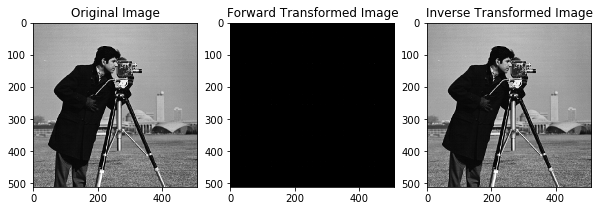

In [9]:
fig, axarr = plt.subplots(1, 3, figsize=(10,7))

axarr[0].imshow(imgeCameraman, cmap=plt.get_cmap('gray'))
axarr[0].set_title('Original Image')

axarr[1].imshow(np.absolute(imgeWalsh), cmap=plt.get_cmap('gray'))
axarr[1].set_title('Forward Transformed Image')

axarr[2].imshow(imgeInverse, cmap=plt.get_cmap('gray'))
axarr[2].set_title("Inverse Transformed Image")
plt.show()

Now, let's compute the running time of Walsh tranform using images with different size

In [10]:
#Generate images
imgSizes = [128, 64, 32, 16, 8]
images = generateImages(imgSizes)

In [11]:
# A list that stores the running time of the DCT algorithm for images with different size.
runningTimeWalsh = []

#For each image...
for i, imge in enumerate(images):
    
    #Compute the image size
    N = imge.shape[0]
    
    print "Computing for ", N, "x", N, "image..."
    
    #Save the starting time.
    startTime = time.time()

    #Compute the DCT of the image.
    walshImge = Walsh.computeForward2DWalshTransform(imge)
    
    #Save the running time
    runningTimeWalsh.append((time.time() - startTime)/60.0)

Computing for  128 x 128 image...
Computing for  64 x 64 image...
Computing for  32 x 32 image...
Computing for  16 x 16 image...
Computing for  8 x 8 image...


In [12]:
result = zip(imgSizes, runningTimeWalsh)
np.savetxt("RunningTimes/runningTimeWalsh.csv", np.array(result), delimiter=',')

The running time will be visualized and compared with the other transformation methods in the next section. As it will be shown, Walsh is faster than DFT as it is only a square waveform where DFT is a complex, sinusoidal transformation.

## The Haar Transform

<a name="HaarIntroduction"></a>
### Introduction

The Haar transform is also one type of the transformation methods. In contrast to Walsh, the kernel functions in Haar are not symmetric. So we need to transpose the first kernel when finding the second one.

The forward transform is computed as follows:

$ H(0, 0, x) = \frac{1}{N} $

$
H(r, m, x) = \left\{
  \begin{array}{l l}
   \frac{2^{r/2}}{\sqrt N} & \quad \text{$ \frac{m-1}{2^r} \leq x \leq \frac{m-1/2}{2^r}$ } \\
   -\frac{2^{r/2}}{\sqrt N} & \quad \text{$ \frac{m-1/2}{2^r} \leq x \leq \frac{m}{2^r}$ }\\
   0 & \quad \text{otherwise}
  \end{array} \right.
$

Where $0 \leq x < 1$, $0 \leq r < log_2 N $ and $1 \leq m \leq 2^r$

<a name="HaarImplementation"></a>
### Python Implementation

It's implementation is as follows:

In [13]:
class Haar(object):
    """
    This class Haar implements all the procedures for transforming a given 2D digital image
    into its corresponding frequency-domain image (Haar Transform)
    """
        
    #Compute the Haar kernel.
    @classmethod
    def computeKernel(self, N):
        """
        Computes/generates the haar kernel function.

        Parameters
        ----------
        N : int
            Size of the kernel to be generated.

        Returns
        -------
        kernel : ndarray
            The generated kernel as a matrix.
        """
        
        i = 0
        kernel = np.zeros([N, N])
        n = int(math.log(N, 2))

        #Fill for the first row of the kernel
        for j in xrange(N):
            kernel[i, j] = 1.0/math.sqrt(N)


        # For the other rows of the kernel....
        i += 1
        for r in xrange(n):
             for m in xrange(1, (2**r)+1):
                j=0
                for x in np.arange(0, 1, 1.0/N):
                    if (x >= (m-1.0)/(2**r)) and (x < (m-0.5)/(2**r)):
                        kernel[i, j] = (2.0**(r/2.0))/math.sqrt(N)
                    elif (x >= (m-0.5)/(2**r)) and (x < m/(2.0**r)):
                        kernel[i, j] = -(2.0**(r/2.0))/math.sqrt(N)
                    else:
                        kernel[i, j] = 0
                    j += 1
                i += 1
        return kernel

    @classmethod
    def computeForward2DHaarTransform(self, imge):
        """
        Computes/generates the 2D Haar transform.

        Parameters
        ----------
        imge : ndarray
            The input image to be transformed.

        Returns
        -------
        final2DHaar : ndarray
            The transformed image.
        """
        
        N = imge.shape[0]
        kernel = Haar.computeKernel(N)

        imge1DHaar = np.dot(kernel, imge) 
        
        #Transpose the kernel as it is not symmetric
        final2DHaar = np.dot(imge1DHaar, kernel.T)

        return final2DHaar/N
    
    @classmethod
    def computeInverse2DHaarTransform(self, imgeHaar):
        """
        Computes/generates the inverse of 2D Haar transform.

        Parameters
        ----------
        imgeHaar : ndarray
            The Haar transformed image.

        Returns
        -------
        imgeInverse : ndarray
            The inverse of the transformed image.
        """
        
        N = imgeHaar.shape[0]
        kernel = Haar.computeKernel(N)

        imge1DInverse = np.dot(kernel.T, imgeHaar)        
        imgeInverse = np.dot(imge1DInverse, kernel)

        return imgeInverse/N
        

<a name="HaarTesting"></a>
### Testing the Code

Now let's try the 4x4 haar kernel:

In [14]:
xKernel = Haar.computeKernel(4)
xKernel

array([[ 0.5       ,  0.5       ,  0.5       ,  0.5       ],
       [ 0.5       ,  0.5       , -0.5       , -0.5       ],
       [ 0.70710678, -0.70710678,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.70710678, -0.70710678]])

Now, we will compute the haar transform of a given image.

In [15]:
imgeHaar = Haar.computeForward2DHaarTransform(imgeCameraman)

Now, let's return back to its original form by using the inverse Haar transform

In [16]:
imgeHaarInverse = Haar.computeInverse2DHaarTransform(imgeHaar)

The range of the results of the Haar transform is:

In [17]:
np.min(np.absolute(imgeHaar)), np.max(np.absolute(imgeHaar))

(0.0, 118.31400299072266)

We can now visualize the original, forward and inverse transformed images as follows:

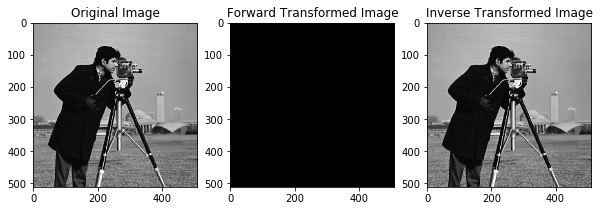

In [18]:
fig, axarr = plt.subplots(1, 3, figsize=(10,7))

axarr[0].imshow(imgeCameraman, cmap=plt.get_cmap('gray'))
axarr[0].set_title('Original Image')

axarr[1].imshow(np.absolute(imgeHaar), cmap=plt.get_cmap('gray'))
axarr[1].set_title('Forward Transformed Image')

axarr[2].imshow(imgeHaarInverse, cmap=plt.get_cmap('gray'))
axarr[2].set_title("Inverse Transformed Image")
plt.show()

Now, we will compute the running time of Haar Transform using images with different sizes:

In [19]:
#Generate images
imgSizes = [128, 64, 32, 16, 8]
images = generateImages(imgSizes)

# A list that stores the running time of the DCT algorithm for images with different size.
runningTimeHaar = []

#For each image...
for i, imge in enumerate(images):
    
    #Compute the image size
    N = imge.shape[0]
    
    print "Computing for ", N, "x", N, "image..."
    
    #Save the starting time.
    startTime = time.time()

    #Compute the Haar of the image.
    haarImge = Haar.computeForward2DHaarTransform(imge)
    
    #Save the running time
    runningTimeHaar.append((time.time() - startTime)/60.0)
    
result = zip(imgSizes, runningTimeHaar)
np.savetxt("RunningTimes/runningTimeHaar.csv", np.array(result), delimiter=',')

Computing for  128 x 128 image...
Computing for  64 x 64 image...
Computing for  32 x 32 image...
Computing for  16 x 16 image...
Computing for  8 x 8 image...


In [20]:
#Load the running time for DFT, Walsh, Haar Transforms
runningTimeDFT = np.loadtxt("RunningTimes/runningTimeDFT.csv", delimiter =',')
runningTimeWalsh = np.loadtxt("RunningTimes/runningTimeWalsh.csv", delimiter =',')
runningTimeHaar = np.loadtxt("RunningTimes/runningTimeHaar.csv", delimiter =',')

['128x128', '64x64', '32x32', '16x16', '8x8']


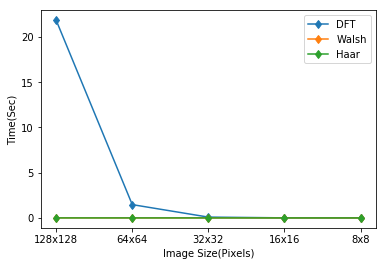

In [21]:
#Plot the running times
plt.plot(xrange(runningTimeDFT.shape[0]), runningTimeDFT[:,1], '-d')
plt.hold
plt.plot(xrange(runningTimeWalsh.shape[0]), runningTimeWalsh[:,1], '-d')
plt.plot(xrange(runningTimeHaar.shape[0]), runningTimeHaar[:,1], '-d')

xlabels = [str(int(imge)) + 'x' + str(int(imge)) for imge in runningTimeDFT[:, 0]]
print xlabels
plt.xticks(xrange(len(runningTimeDFT[:, 0])), xlabels)
plt.xlabel("Image Size(Pixels)")
plt.ylabel("Time(Sec)")
plt.legend(['DFT', 'Walsh', 'Haar'])
plt.show()

As we can see from the graph above, both Walsh and Haar are faster than DFT but are not as precise as the DFT. Because DFT is a complex sinusoidal wave.